# 3.1 MLP(Multi-Layer Perceptron) 구축과 학습

MLP는 선형 계층을 연결한 것. 첫번째 층 -> 입력층 / 마지막 층 -> 출력층

In [44]:
import torch
from torch import nn

net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)
# nn.Sequential 은 nn.Module 층을 차례로 쌓아서 신경망 구축할 때 사용

# ReLU는 f(x) = max(0,x)라는 형태를 하고 있어서 x>0인 영역에서는 항상 미분이 유한한 값으로 소실되지 않는다.

In [39]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
digits = load_digits()

x = digits.data
y = digits.target

# NumPy의 ndarray를 파이토치의 텐서로 변환
x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.int64)

# 소프트맥스 크로스 엔트로피
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 손실 함수의 로그
losses = []

for epoc in range(100):
    optimizer.zero_grad()
    y_pred = net(x)
    
    # MSE loss와 w를 사용한 미분 게산
    loss = loss_fn(y_pred, y)
    loss.backward()
    
    optimizer.step()
    # 수렴 확인을 위해 loss를 기록해 둔다.
    losses.append(loss.item())


In [34]:
x = x.to("cuda:0")
y = y.to("cuda:0")

net.to("cuda:0")

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

# 3.2 DataSet과 DataLoader
데이터가 늘어나거나 신경망 계층의 증가, 파라미터가 늘어나면 전체 데이터를 메모리에서 처리하기 어려워진다.

TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너이다. 이 TensorDataset을 DataLoader에 전달하면 for루프에서 데이터의 일부만 간단히 추출!

In [40]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Dataset 작성
ds = TensorDataset(x,y)

# 순서로 섞어서 64개씩 데이터를 반환하는 Dataloader 작성
loader = DataLoader(ds,batch_size=64,shuffle=True)

net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 최적화 실행
losses = []
for epoch in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yy는 64개만 받는다
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)

# 3.3 학습 효율화 팁
훈려된 데이터와 만 궁합이 좋아서 다른 데이터에 적용할 수 없거나 훈련이 불안정해 시간이 오래 걸리는 문제.
## 이 두 가지를 해결하기 위해 Dropout과 Batch Normalization!

In [47]:
import torch
from torch import nn, optim
# 데이터를 훈련용과 검증용으로 분할
from sklearn.model_selection import train_test_split
# 전체의 30%는 검증용
x = digits.data
y = digits.target
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# 여러 층을 쌓아서 깊은 신경망을 구축한다.
k = 100
net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 훈련용 데이터로 DataLoader를 작성
ds = TensorDataset(x_train, y_train)
loader = DataLoader(ds, batch_size = 32, shuffle = True)

In [48]:
train_losses = []
test_losses = []

for epoch in range(100):
    running_loss = 0.0
    for i, (xx,yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(x_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

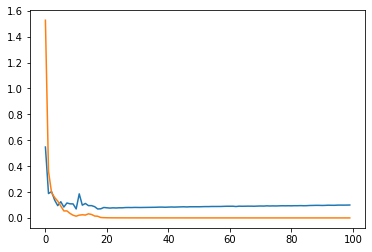

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)

In [53]:
# 과학습을 방지시키는 것 -> 정규화(regularization)   여러가지가 있지만 신경망에서는 Dropout을 사용
# Dropout은 신경망 훈련시에만 사용, 예측시 사용하지 않는 것이 일반적
# 확률 0.5로 랜덤으로 변수의 차원을 버리는 Dropout을 각 층에 추가
net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,10)
)


In [54]:
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # 신경망을 훈련 모드로 설정
    net.train()
    for i,(xx,yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
    train_losses.append(running_loss / i)
    # 신경망을 평가모드로 설정하고 검증 데이터의 손실 함수를 계산
    # 검증 데이터의 손실 함수를 게산
    net.eval()
    y_pred = net(x_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

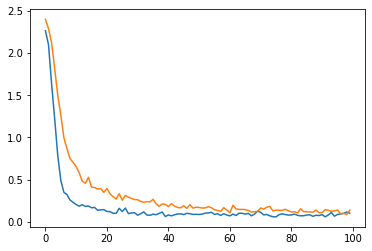

In [55]:
plt.plot(test_losses)
plt.plot(train_losses)

## 3.3.2 Batch Normalization를 사용한 학습 가속

훈련시에만 적용하고 평가시에는 적용하지 않는다.
Dropout과 동일하게 train과 eval 메소드 모드를 적용하거나 미적용할 수 있다.

In [59]:
# Linear층에는 BatchNorm1d를 적용한다.
net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,10)
)

# 3.4 신경망의 모듈화
자체 신경망 계층을 만들어서 재사용하거나 이것을 부품으로 사용해 더 복잡한 신경망을 만들 수 있다.

In [64]:
class CustomLinear(nn.Module):
    def __init__(self, in_features,
                        out_features,
                        bias = True, p = 0.5):
        super().__init__()
        self.linear = nn.Linear(in_features,
                                out_features,
                                bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

mlp = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200,10)
)

In [65]:
class MyMLP(nn.Module):
    def __init__(self, in_features,
                        out_features,
                        bias = True, p = 0.5):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, out_features)
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x
    
mlp = MyMLP(64,10)

In [68]:
print(mlp)

MyMLP(
  (ln1): CustomLinear(
    (linear): Linear(in_features=64, out_features=200, bias=True)
    (relu): ReLU()
    (drop): Dropout(p=0.5)
  )
  (ln2): CustomLinear(
    (linear): Linear(in_features=200, out_features=200, bias=True)
    (relu): ReLU()
    (drop): Dropout(p=0.5)
  )
  (ln3): CustomLinear(
    (linear): Linear(in_features=200, out_features=200, bias=True)
    (relu): ReLU()
    (drop): Dropout(p=0.5)
  )
  (ln4): CustomLinear(
    (linear): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
    (drop): Dropout(p=0.5)
  )
)
